# Importing Libraries

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Loading Dataset

In [2]:
train_data_dir = 'C:/Users/mohda/Documents/Projects/brain_mri2/dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data 

,filepaths,labels
0,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
1,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
2,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
3,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
4,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
...,...,...
5707,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
5708,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
5709,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
5710,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary


In [3]:
test_data_dir = 'C:/Users/mohda/Documents/Projects/brain_mri2/dataset/Testing' 
filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir,fold)
    filelist = os.listdir(foldpath) 
    for file in filelist:
        fpath = os.path.join(foldpath,file)
        filepaths.append (fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths,name = 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
dt = pd.concat([Fseries,Lseries],axis='columns')
dt 

,filepaths,labels
0,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
1,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
2,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
3,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
4,C:/Users/mohda/Documents/Projects/brain_mri2/d...,glioma
...,...,...
1306,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
1307,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
1308,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary
1309,C:/Users/mohda/Documents/Projects/brain_mri2/d...,pituitary


# Splitting Dataset

In [4]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [5]:
batch_size=8
img_size = (224,224)
channels = 3 
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.


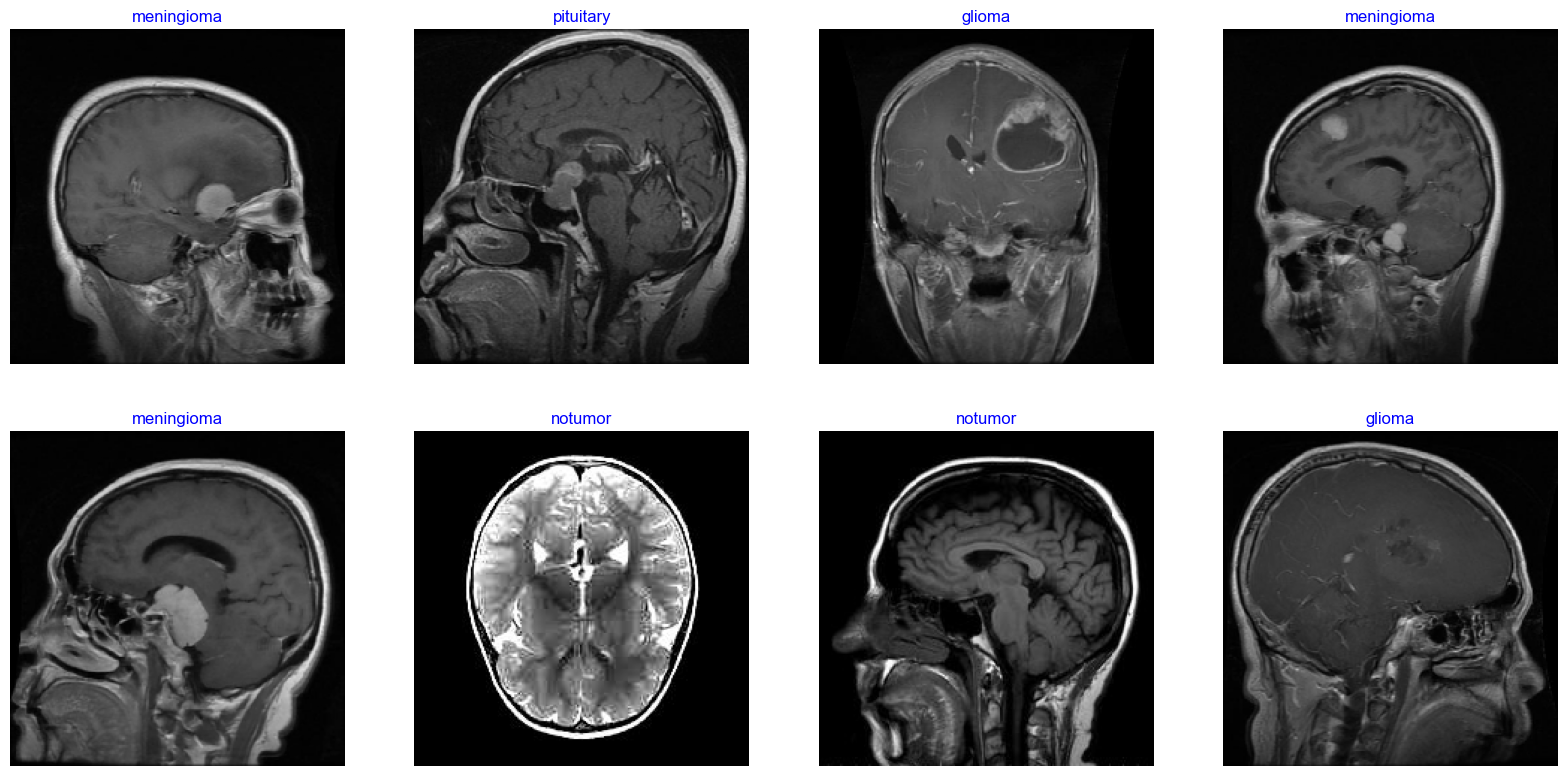

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(8):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

# EfficientNet Model

In [7]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',Precision(),Recall()])

model.summary()
Model: "sequential_1"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_______________________________________

In [8]:
epochs = 7
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/7
714/714 [==============================] - 366s 485ms/step - loss: 5.8094 - accuracy: 0.8249 - precision: 0.8462 - recall: 0.8036 - val_loss: 3.6709 - val_accuracy: 0.9573 - val_precision: 0.9600 - val_recall: 0.9527
Epoch 2/7
714/714 [==============================] - 347s 486ms/step - loss: 2.5282 - accuracy: 0.9350 - precision: 0.9466 - recall: 0.9184 - val_loss: 1.5800 - val_accuracy: 0.9664 - val_precision: 0.9782 - val_recall: 0.9588
Epoch 3/7
714/714 [==============================] - 347s 486ms/step - loss: 1.1623 - accuracy: 0.9580 - precision: 0.9662 - recall: 0.9454 - val_loss: 0.7236 - val_accuracy: 0.9863 - val_precision: 0.9877 - val_recall: 0.9832
Epoch 4/7
714/714 [==============================] - 348s 487ms/step - loss: 0.5870 - accuracy: 0.9785 - precision: 0.9828 - recall: 0.9725 - val_loss: 0.4019 - val_accuracy: 0.9924 - val_precision: 0.9924 - val_recall: 0.9908
Epoch 5/7
714/714 [==============================] - 354s 496ms/step - loss: 0.3535 - accura

# Plotting Data

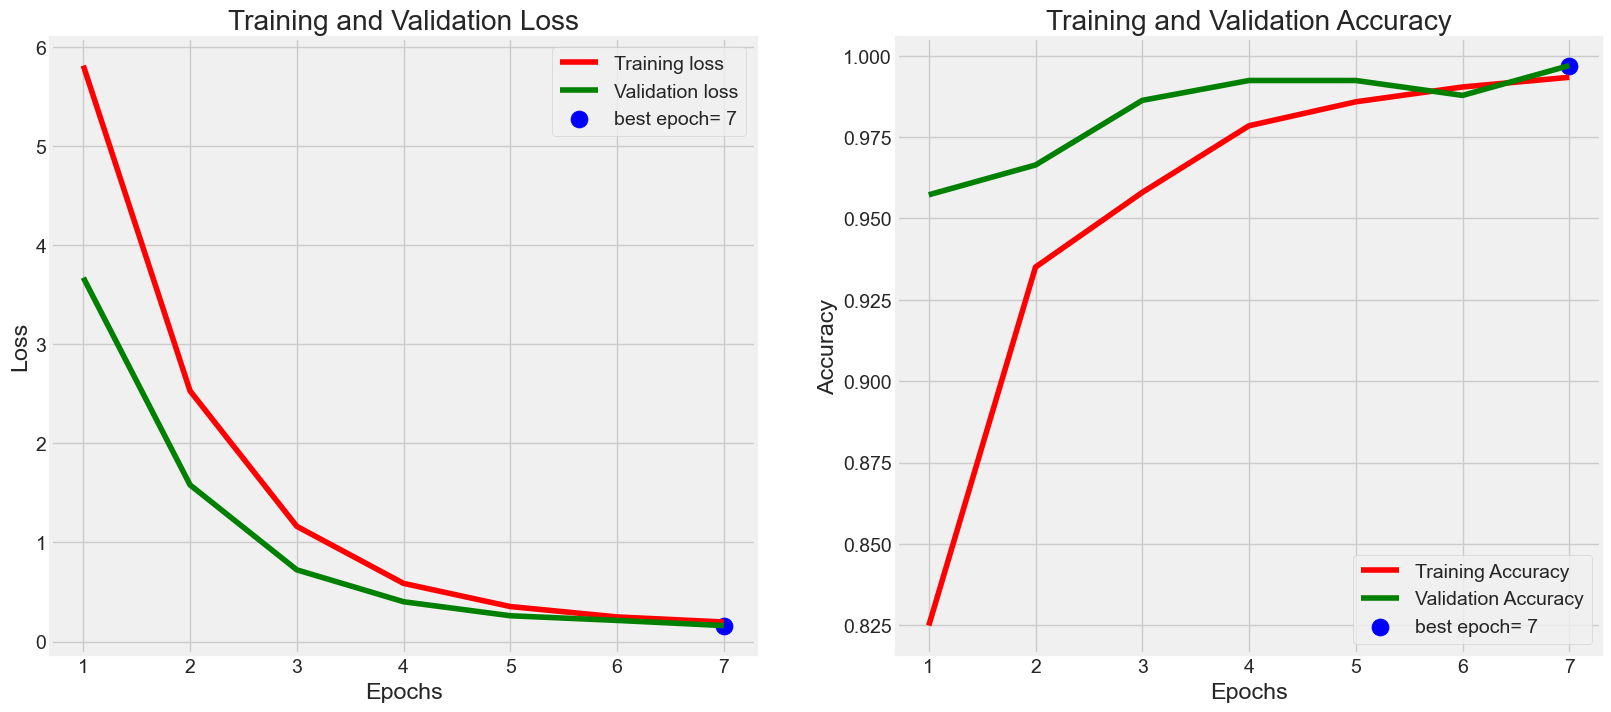

In [9]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [10]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

82/82 [==============================] - 8s 92ms/step - loss: 0.1765 - accuracy: 0.9924 - precision: 0.9924 - recall: 0.9924
Train Loss: 0.1502
Train Accuracy: 99.89%
--------------------
Validation Loss: 0.1615
Validation Accuracy: 99.69%
--------------------
Test Loss: 0.1765
Test Accuracy: 99.24%


In [11]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

82/82 [==============================] - 9s 83ms/step


In [12]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[163,   1,   0,   0],
       [  2, 146,   2,   0],
       [  0,   0, 193,   0],
       [  0,   0,   0, 149]], dtype=int64)

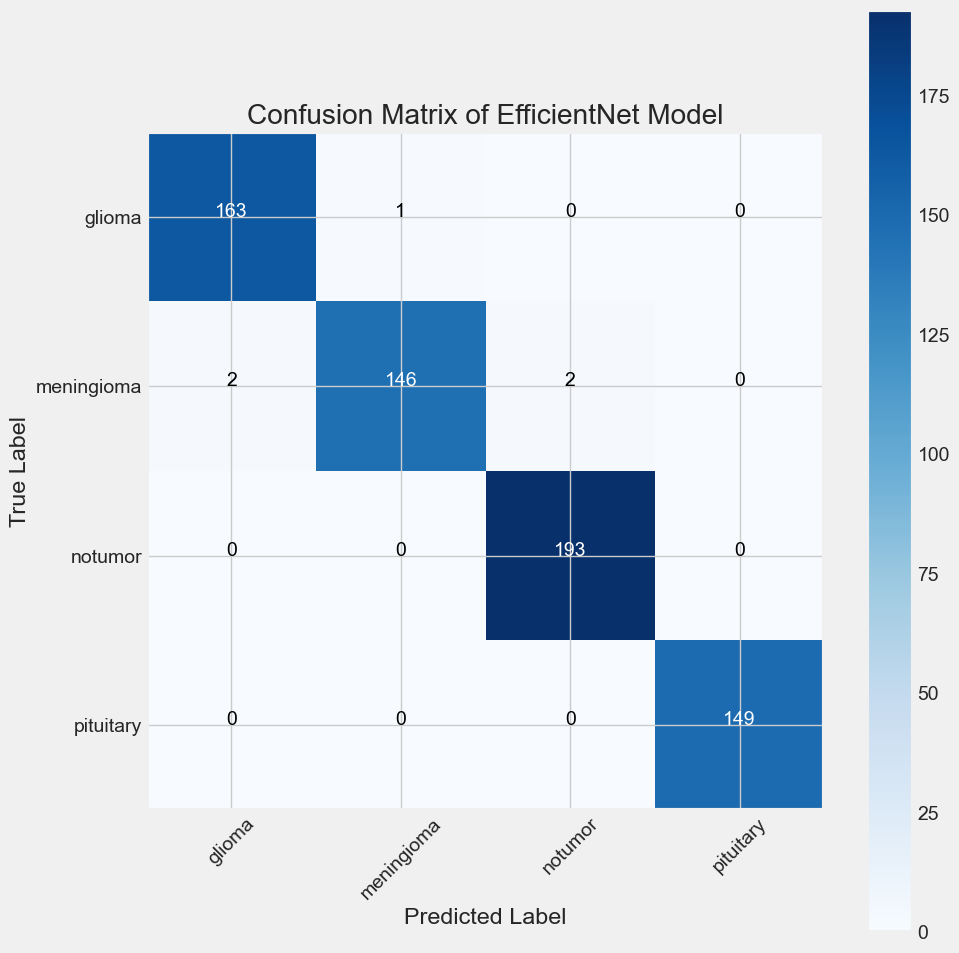

In [13]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix of EfficientNet Model')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Saving Model

In [37]:
model.save("efficientNet.h5")

# Xception Model

In [14]:
img_shape=(224,224,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
model_02 = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model_02.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',Precision(),Recall()])

model_02.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21,124,268
Trainable params: 21,069,740


In [35]:
history_02 = model_02.fit(train_gen,
                 epochs=5,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/5
714/714 [==============================] - 314s 439ms/step - loss: 0.0242 - accuracy: 0.9933 - precision_1: 0.9933 - recall_1: 0.9933 - val_loss: 0.0475 - val_accuracy: 0.9817 - val_precision_1: 0.9817 - val_recall_1: 0.9817
Epoch 2/5
714/714 [==============================] - 438s 614ms/step - loss: 0.0120 - accuracy: 0.9963 - precision_1: 0.9965 - recall_1: 0.9961 - val_loss: 0.0524 - val_accuracy: 0.9893 - val_precision_1: 0.9893 - val_recall_1: 0.9893
Epoch 3/5
714/714 [==============================] - 493s 690ms/step - loss: 0.0108 - accuracy: 0.9961 - precision_1: 0.9961 - recall_1: 0.9958 - val_loss: 0.0261 - val_accuracy: 0.9924 - val_precision_1: 0.9924 - val_recall_1: 0.9924
Epoch 4/5
714/714 [==============================] - 485s 679ms/step - loss: 0.0138 - accuracy: 0.9967 - precision_1: 0.9967 - recall_1: 0.9963 - val_loss: 0.0209 - val_accuracy: 0.9954 - val_precision_1: 0.9954 - val_recall_1: 0.9954
Epoch 5/5
714/714 [==============================] - 494s 69

# Plotting Data

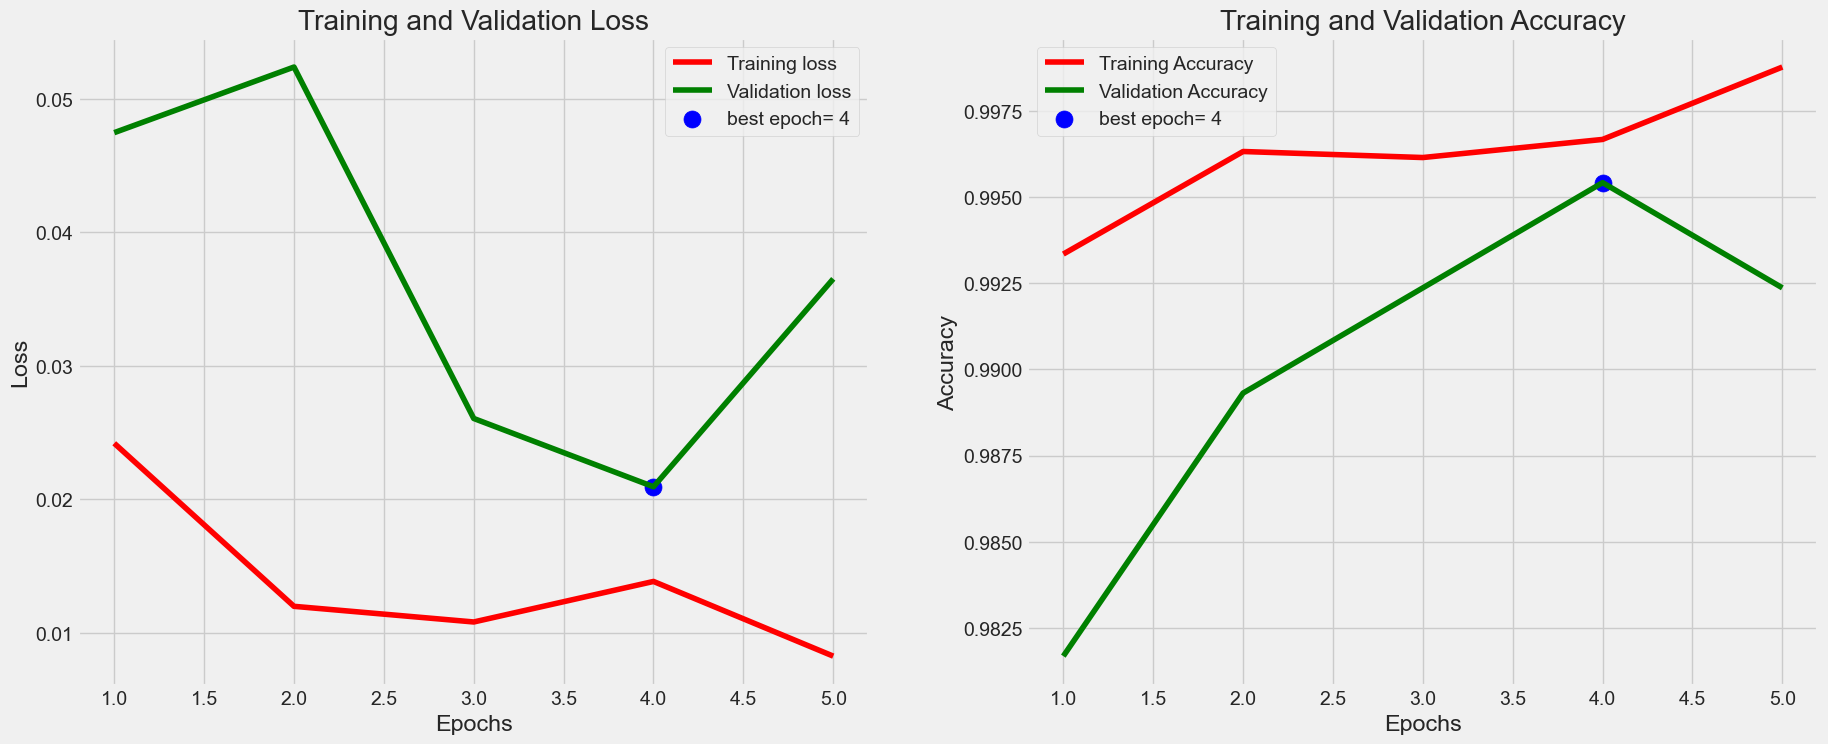

In [36]:
tr_acc = history_02.history['accuracy']
tr_loss = history_02.history['loss']
val_acc = history_02.history['val_accuracy']
val_loss = history_02.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [37]:
train_score = model_02.evaluate(train_gen, verbose=1)
valid_score = model_02.evaluate(valid_gen, verbose=1)
test_score = model_02.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

82/82 [==============================] - 7s 84ms/step - loss: 0.0404 - accuracy: 0.9939 - precision_1: 0.9939 - recall_1: 0.9939
Train Loss: 0.0002
Train Accuracy: 99.98%
--------------------
Validation Loss: 0.0365
Validation Accuracy: 99.24%
--------------------
Test Loss: 0.0404
Test Accuracy: 99.39%


In [38]:
preds = model_02.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

82/82 [==============================] - 6s 78ms/step


In [39]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[160,   4,   0,   0],
       [  0, 150,   0,   0],
       [  0,   0, 193,   0],
       [  0,   0,   0, 149]], dtype=int64)

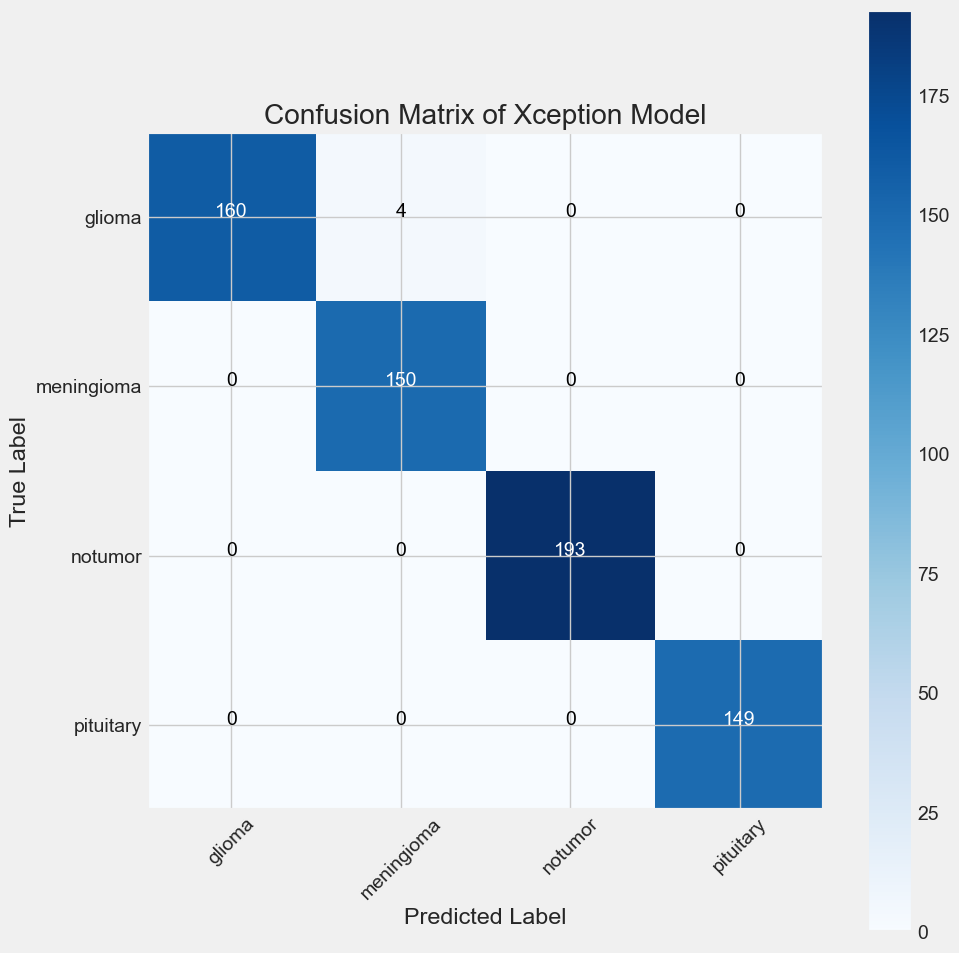

In [40]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix of Xception Model')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Saving Model

In [ ]:
model_02.save("Xception.h5")

# DenseNet Model

In [20]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.DenseNet121(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model_03 = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model_03.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy',Precision(),Recall()])

model_03.summary()
Model: "sequential_1"

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 7,305,028
Trainable params: 7,219,332
Non-trainable params: 85,696
_______________________________________

In [21]:
epochs = 7
history_03 = model_03.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/7
714/714 [==============================] - 195s 253ms/step - loss: 3.7463 - accuracy: 0.8421 - precision_2: 0.8702 - recall_2: 0.8109 - val_loss: 2.2816 - val_accuracy: 0.9099 - val_precision_2: 0.9226 - val_recall_2: 0.8916
Epoch 2/7
714/714 [==============================] - 224s 315ms/step - loss: 1.4723 - accuracy: 0.9331 - precision_2: 0.9498 - recall_2: 0.9142 - val_loss: 1.0443 - val_accuracy: 0.9221 - val_precision_2: 0.9369 - val_recall_2: 0.9069
Epoch 3/7
714/714 [==============================] - 258s 361ms/step - loss: 0.7574 - accuracy: 0.9529 - precision_2: 0.9625 - recall_2: 0.9386 - val_loss: 0.5924 - val_accuracy: 0.9466 - val_precision_2: 0.9505 - val_recall_2: 0.9389
Epoch 4/7
714/714 [==============================] - 265s 371ms/step - loss: 0.4717 - accuracy: 0.9667 - precision_2: 0.9736 - recall_2: 0.9550 - val_loss: 0.4252 - val_accuracy: 0.9603 - val_precision_2: 0.9671 - val_recall_2: 0.9435
Epoch 5/7
714/714 [==============================] - 279s 39

# Plotting Data

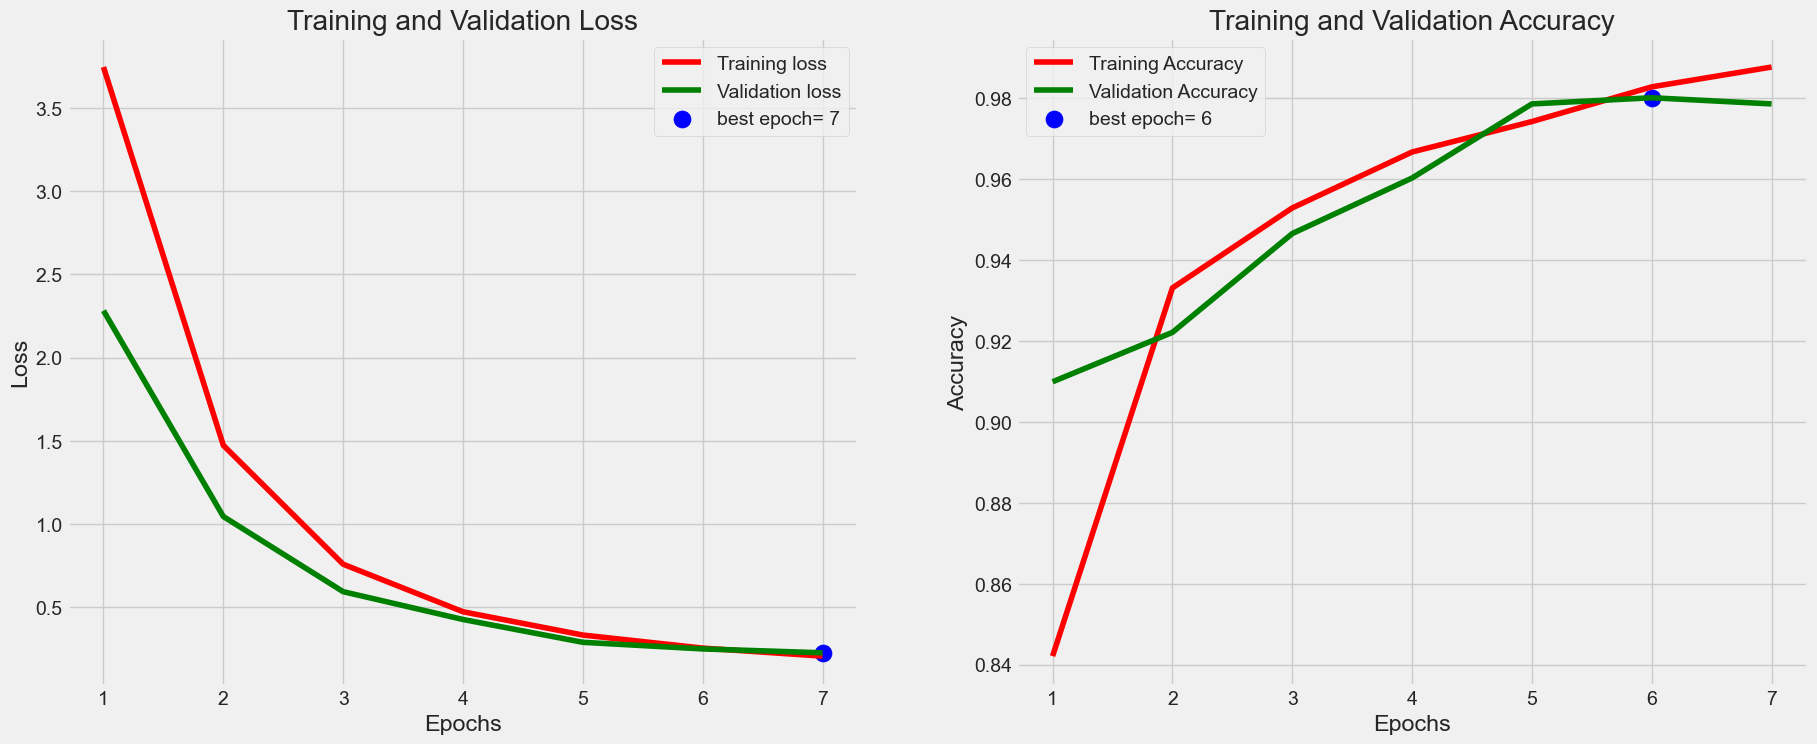

In [22]:
tr_acc = history_03.history['accuracy']
tr_loss = history_03.history['loss']
val_acc = history_03.history['val_accuracy']
val_loss = history_03.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [23]:
train_score = model_03.evaluate(train_gen, verbose=1)
valid_score = model_03.evaluate(valid_gen, verbose=1)
test_score = model_03.evaluate(test_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

82/82 [==============================] - 7s 81ms/step - loss: 0.2021 - accuracy: 0.9787 - precision_2: 0.9802 - recall_2: 0.9787
Train Loss: 0.1602
Train Accuracy: 99.51%
--------------------
Validation Loss: 0.2249
Validation Accuracy: 97.86%
--------------------
Test Loss: 0.2021
Test Accuracy: 97.87%


In [24]:
preds = model_03.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

82/82 [==============================] - 7s 70ms/step


In [25]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm 

array([[151,  12,   0,   1],
       [  1, 149,   0,   0],
       [  0,   0, 193,   0],
       [  0,   0,   0, 149]], dtype=int64)

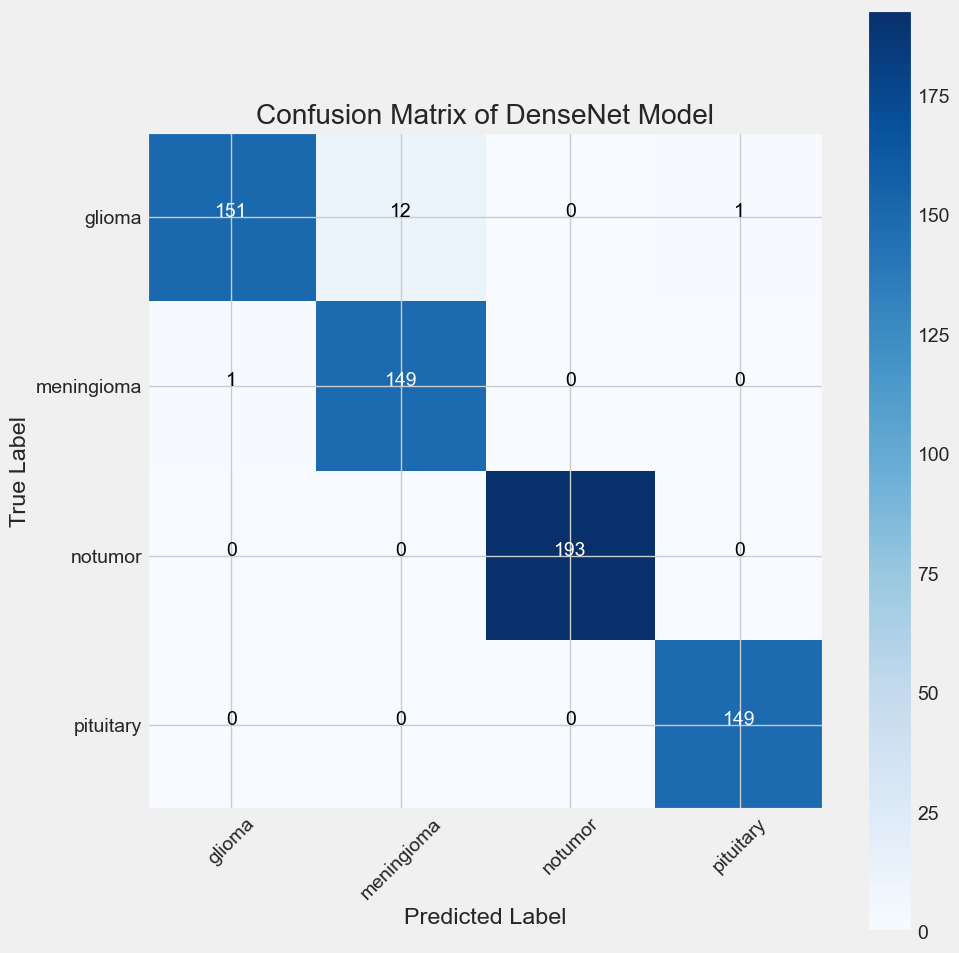

In [26]:
plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix of DenseNet Model')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Saving Model

In [53]:
model_03.save("DenseNet.h5")

# Comparing all model

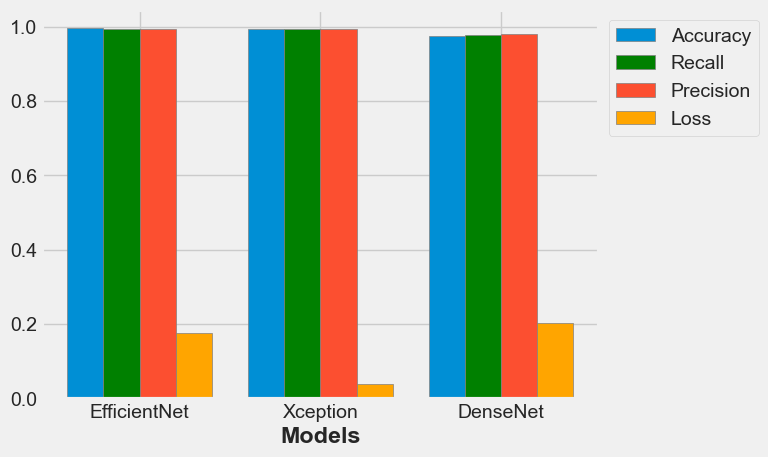

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['EfficientNet', 'Xception', 'DenseNet']
accuracy = [0.9954, 0.9939, 0.9741]
recall = [0.9924, 0.9939, 0.9787]
precision = [0.9924, 0.9939, 0.9802]
loss = [0.1765, 0.0404, 0.2021]

# Set width of bars
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(accuracy))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Plotting
plt.bar(r1, accuracy, width=barWidth, edgecolor='grey', label='Accuracy')
plt.bar(r2, recall, color='g', width=barWidth, edgecolor='grey', label='Recall')
plt.bar(r3, precision, width=barWidth, edgecolor='grey', label='Precision')
plt.bar(r4, loss, color='orange', width=barWidth, edgecolor='grey', label='Loss')

# Add xticks on the middle of the group bars
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + barWidth*1.5 for r in range(len(accuracy))], models)

# Create legend & Show graphic
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
